# 分箱实验

核心假设：当在“之前记录过类似等级”，但又比之前数值上高的时候，这次会不会判断出错配？

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
import os
from hydra import compose, initialize

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

In [3]:
from past1000.calibration import load_nat_data

datasets, uncertainties = load_nat_data(
    folder=cfg.ds.noaa,
    includes=cfg.ds.includes,
    start_year=1000,
    standardize=True,
)
datasets.tail()

Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
2025-06-29  14:13:10 INFO Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 18 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
2025-06-29  14:13:10 INFO Found 18 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 7 files matching the pattern.
2025-06-29  14:13:10 INFO Found 7 files matching the pattern.


,north-china-precip2010,shanxi2015precip,tan2011precip-noaa,xu2023-asm,qinling2016precip,north-china-temp-precip2011,hexi2019scpdsi
year,,,,,,,
2009,NaN,NaN,NaN,-1.466621,-0.568723,NaN,-0.809462
2010,NaN,NaN,NaN,1.170888,0.307108,NaN,0.515620
2011,NaN,NaN,NaN,1.248765,NaN,NaN,-1.255668
2012,NaN,NaN,NaN,-1.204711,NaN,NaN,NaN
2013,NaN,NaN,NaN,0.140132,NaN,NaN,NaN


In [4]:
from past1000.api.mc import combine_reconstructions, plot_combined_reconstruction
from mksci_font import config_font

# 同时还可以修改字号，以及其它任何 rcParams 支持的属性
config_font({"font.size": 9})

combined, trace = combine_reconstructions(datasets, uncertainties)
combined.head()

Initializing NUTS using jitter+adapt_diag...
2025-06-29  14:13:11 INFO Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
2025-06-29  14:13:13 INFO Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]
2025-06-29  14:13:13 INFO NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
2025-06-29  14:13:28 INFO Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,-0.469,0.453,-1.300,0.412
1001,-0.071,0.474,-0.959,0.814
1002,0.124,0.532,-0.905,1.103
1003,-0.300,0.669,-1.505,0.990
1004,-0.908,0.657,-2.167,0.320


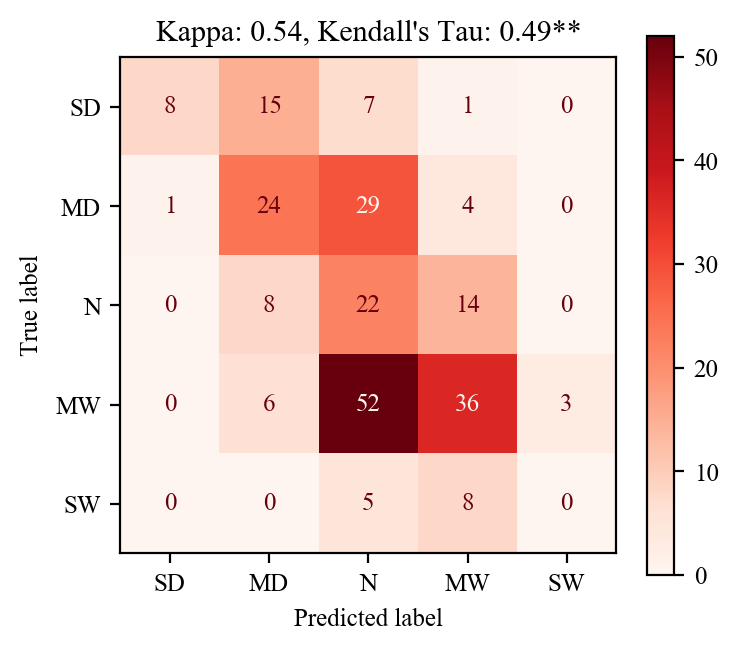

In [5]:
from past1000.viz.plot import plot_confusion_matrix
from past1000.filters import classify
from past1000.utils.calc import detrend_with_nan
import seaborn as sns
import matplotlib.pyplot as plt

from past1000.api.series import HistoricalRecords
from mksci_font import config_font

palette = plt.get_cmap("coolwarm").reversed()

config_font({"font.size": 9})
START = 1000
STAGE1 = 1469
STAGE2 = 1659
END = 1949
LABELS = ["1000-1469", "1469-1649", "1649-1949", "1949-2020"]
SLICE = slice(STAGE1, END)

# The commented out code is creating an instance of the `HistoricalRecords` class from the `past1000.api.series` module. It is passing the `shp_path` and `data_path` parameters to the constructor of `HistoricalRecords` class using values from `cfg.ds.atlas.shp` and `cfg.ds.atlas.file` respectively.
history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
)
history.to_series(inplace=True, interpolate=None, name="historical_mean", how="mode")

HISTORICAL_RECORDS = history.data.loc[SLICE]
NATURAL_RECORDS = combined["mean"].loc[SLICE]
DETREND_N = detrend_with_nan(NATURAL_RECORDS)


plot_confusion_matrix(
    y_true=HISTORICAL_RECORDS,
    y_pred=classify(NATURAL_RECORDS),
    dropna=True,
);

我要找的应该是 last 列应该是和这一次 classified 的等级一样的、上一次的 expect

In [6]:
def generate_last_column_by_classified(
    df, value_col="value", expect_col="expect", classify_col="classified"
):
    """
    生成 last 列：上一次 classified 等级与当前相同的 expect 的 value
    """
    df = df.copy()
    df["last"] = np.nan
    # 按 classified 分组，对每组的 expect 的 value shift
    for c in df[classify_col].unique():
        mask = df[classify_col] == c
        df.loc[mask, "last"] = df.loc[mask, value_col].shift(1)
    return df["last"]


def check_estimation(
    data: pd.DataFrame,
    value_col: str = "value",
    expect_col: str = "expect",
    classify_col: str = "classified",
):
    """找到 h_data 里在 classify 中被归类为同一个级别的值，对比相同索引"""
    data["exact"] = data[expect_col] == data[classify_col]
    data["last"] = generate_last_column_by_classified(
        data, value_col, expect_col, classify_col
    )
    data["diff"] = data[value_col] - data["last"]
    return data


test_df = pd.DataFrame(
    {
        "value": [0.11, 0.34, 1.10, 0.10, 0.32, 0.33, 3.0, 0.11],
        "classified": [0, 1, 2, -1, 2, 0, 2, 0],
        "expect": [0, 1, 1, 0, 2, 2, 2, 0],
    }
)

test_df = check_estimation(test_df, "value", "expect", "classified")
test_df

,value,classified,expect,exact,last,diff
0,0.11,0,0,True,NaN,NaN
1,0.34,1,1,True,NaN,NaN
2,1.10,2,1,False,NaN,NaN
3,0.10,-1,0,False,NaN,NaN
4,0.32,2,2,True,1.10,-0.78
5,0.33,0,2,False,0.11,0.22
6,3.00,2,2,True,0.32,2.68
7,0.11,0,0,True,0.33,-0.22


In [7]:
import seaborn as sns
from matplotlib import pyplot as plt


def analyze_misclassification_pivot(
    df, expect_col="expect", classified_col="classified", diff_col="diff"
):
    """
    使用 pandas pivot_table 分析被错判组合的平均 diff
    """
    # 只选择被错判的行
    misclassified = df[~df["exact"]].copy()

    if len(misclassified) == 0:
        print("没有找到错判的数据")
        return pd.DataFrame()

    # 使用 pivot_table 创建矩阵
    pivot_matrix = pd.pivot_table(
        misclassified,
        values=diff_col,
        index=expect_col,
        columns=classified_col,
        aggfunc="mean",  # 计算平均值
        fill_value=np.nan,
    )

    return pivot_matrix

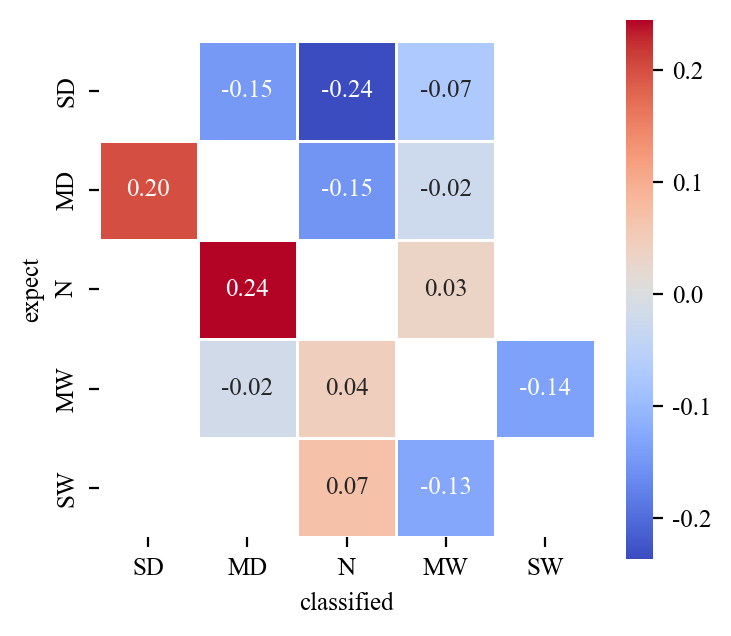

In [8]:
from past1000.viz.plot import TICK_LABELS

df = pd.DataFrame(
    {
        "value": NATURAL_RECORDS,
        "expect": HISTORICAL_RECORDS,
        "classified": classify(NATURAL_RECORDS),
    }
)
actual_checked_df = check_estimation(df)
actual_diff = analyze_misclassification_pivot(actual_checked_df)

fig, ax2 = plt.subplots(figsize=(4, 3.5))
sns.heatmap(
    actual_diff,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    ax=ax2,
    linewidths=0.5,
)
ax2.set_xticklabels(TICK_LABELS)
ax2.set_yticklabels(TICK_LABELS)
plt.show();

<Axes: xlabel='diff', ylabel='Count'>

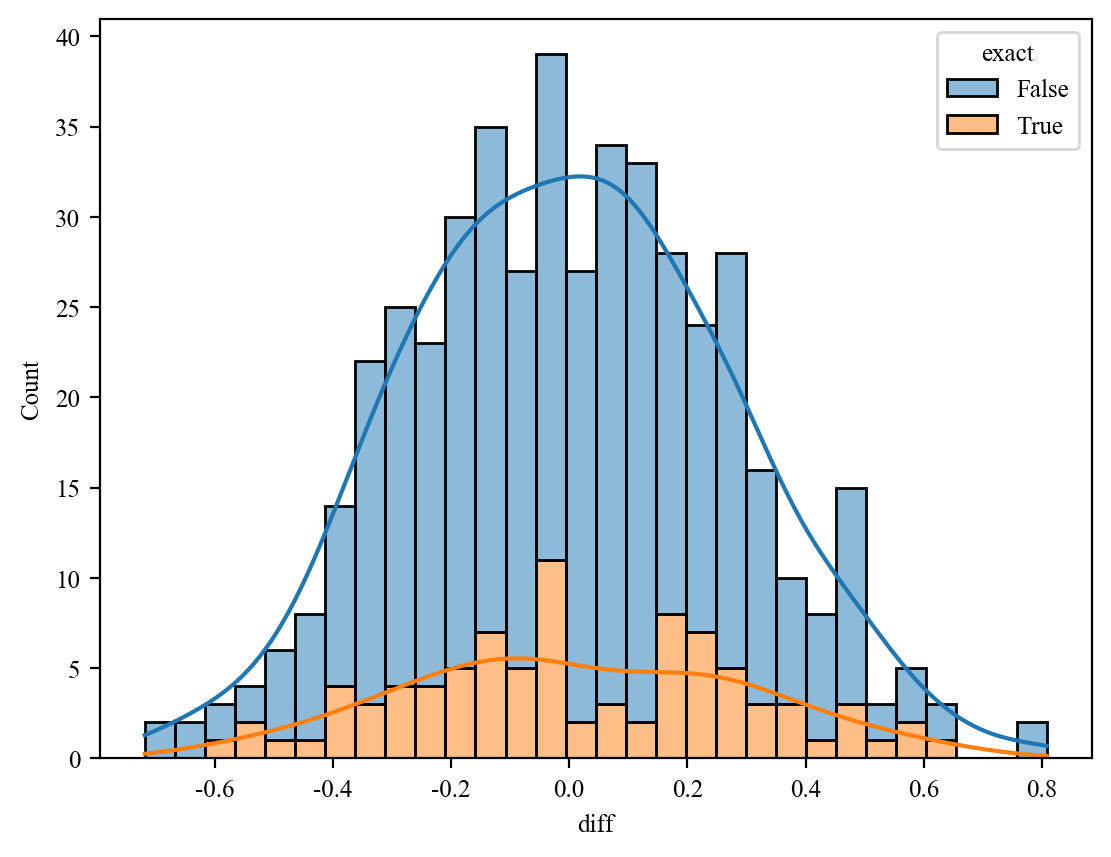

In [9]:
sns.histplot(
    actual_checked_df,
    x="diff",
    hue="exact",
    multiple="stack",
    alpha=0.5,
    bins=30,
    kde=True,
)

## 蒙特卡洛分析

对比随机模式的测不准情况会怎么样？

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  # 用于显示进度条
from past1000.filters import classify
from scipy.stats import norm


# --- 蒙特卡洛模拟主函数 ---
def run_mc_simulation(n_runs=1000, n_samples=100):
    """
    运行蒙特卡洛模拟，返回平均 diff 矩阵和标准差矩阵。

    Parameters:
    -----------
    n_runs : int
        模拟运行的次数。
    n_samples : int
        每次模拟生成的样本数量。

    Returns:
    --------
    tuple[pd.DataFrame, pd.DataFrame]
        返回 (平均diff矩阵, 标准差diff矩阵)。
    """
    all_diff_matrices = []

    print(f"Running {n_runs} Monte Carlo simulations...")
    for _ in tqdm(range(n_runs)):
        # 1. 生成随机数据
        random_data = np.random.normal(0, 1, n_samples)
        random_expect = np.random.choice(
            [-2, -1, 0, 1, 2], size=n_samples, p=[0.1, 0.2, 0.4, 0.2, 0.1]
        )
        random_df = pd.DataFrame(
            {
                "value": random_data,
                "expect": random_expect,
                "classified": classify(random_data),
            }
        )

        # 2. 计算并获取 diff 矩阵
        checked_df = check_estimation(random_df)
        diff_matrix = analyze_misclassification_pivot(checked_df)
        if not diff_matrix.empty:
            all_diff_matrices.append(diff_matrix)

    if not all_diff_matrices:
        print("Warning: No misclassifications found in any simulation run.")
        return pd.DataFrame(), pd.DataFrame()

    # 3. 将所有矩阵堆叠并计算均值和标准差
    # 使用 concat 和 groupby 可以优雅地处理每次模拟中维度不一致的问题
    combined_matrices = pd.concat(all_diff_matrices)

    # --- 这里是修正的部分 ---
    # 只按 level=0 (即 'expect' 索引) 分组，并且不再需要 unstack()
    mean_matrix = combined_matrices.groupby(level=0).mean()
    std_matrix = combined_matrices.groupby(level=0).std()
    # --- 修正结束 ---

    # 为了保持一致的行列顺序
    all_levels = sorted(list(set(mean_matrix.index) | set(mean_matrix.columns)))
    mean_matrix = mean_matrix.reindex(index=all_levels, columns=all_levels)
    std_matrix = std_matrix.reindex(index=all_levels, columns=all_levels)

    return mean_matrix, std_matrix


# --- 如何使用 ---

# 1. 运行模拟
mean_diff_random, std_diff_random = run_mc_simulation(n_runs=1000, n_samples=1000)


# --- 1. 计算 Z-score 矩阵 ---
# (确保 mean_diff_random 和 std_diff_random 已经通过模拟计算出来)

# 确保矩阵的行列索引一致，方便计算
all_levels = sorted(
    list(
        set(actual_diff.index) | set(actual_diff.columns) | set(mean_diff_random.index)
    )
)
actual_diff_matrix = actual_diff.reindex(index=all_levels, columns=all_levels)
mean_diff_random = mean_diff_random.reindex(index=all_levels, columns=all_levels)
std_diff_random = std_diff_random.reindex(index=all_levels, columns=all_levels)

z_score_matrix = (actual_diff_matrix - mean_diff_random) / std_diff_random

# --- 2. 设置显著性水平并找出显著的单元格 ---
alpha = 0.1
# 计算双尾检验的临界 Z 值
critical_z = norm.ppf(1 - alpha / 2)
print(f"显著性水平 alpha = {alpha}")
print(f"对应的临界 Z 值 (双尾) = {critical_z:.3f}")

# --- (可选) 4. 计算并可视化 P 值矩阵 ---
# 将 Z-score 转换为 P 值 (双尾)
p_value_matrix = z_score_matrix.apply(lambda z: 2 * (1 - norm.cdf(abs(z))))

Running 1000 Monte Carlo simulations...


  0%|          | 0/1000 [00:00<?, ?it/s]

显著性水平 alpha = 0.1
对应的临界 Z 值 (双尾) = 1.645


In [11]:
p_value_matrix

classified,-2.0,-1.0,0.0,1.0,2.0
expect,,,,,
-2.0,NaN,0.024625,0.000008,0.280607,NaN
-1.0,0.070292,NaN,0.000003,0.540312,NaN
0.0,NaN,0.000000,NaN,0.203415,NaN
1.0,NaN,0.736439,0.177326,NaN,0.238278
2.0,NaN,NaN,0.167145,0.052463,NaN


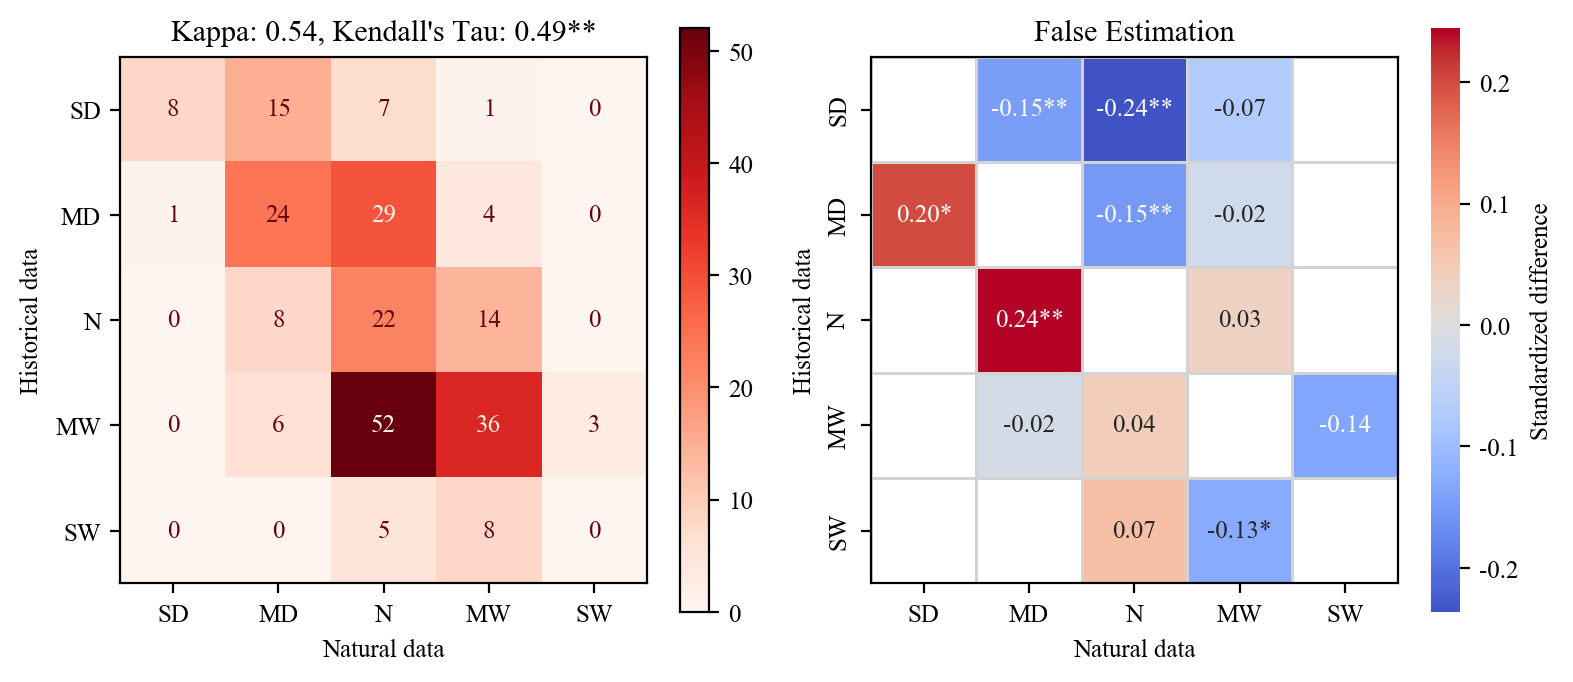

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from past1000.utils.calc import align_matrices, fill_star_matrix


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))

## 图1：混淆矩阵
plot_confusion_matrix(
    y_true=HISTORICAL_RECORDS,
    y_pred=classify(NATURAL_RECORDS),
    dropna=True,
    ax=ax1,
)

## 图2：热力图
# --- 1. 确保所有矩阵的索引和列对齐 ---
# (这是一个好的实践，以避免计算错误)
actual_diff_aligned, mean_diff_aligned, std_diff_aligned = align_matrices(
    actual_diff,
    mean_diff_random,
    std_diff_random,
)

# --- 2. 计算 Z-score 和 P-value 矩阵 ---
z_score_matrix = (actual_diff_aligned - mean_diff_aligned) / std_diff_aligned
p_value_matrix = z_score_matrix.apply(lambda z: 2 * (1 - norm.cdf(abs(z))))

annot_labels = fill_star_matrix(p_value_matrix, actual_diff_aligned)

sns.heatmap(
    actual_diff_aligned,
    annot=annot_labels,  # 使用我们自定义的标签矩阵
    fmt="s",  # "s" 表示我们提供的是字符串格式
    cmap="coolwarm",
    square=True,
    ax=ax2,
    linewidths=0.5,
    cbar_kws={"label": "Standardized difference"},  # 给颜色条加个标签
    center=0,
    linecolor="lightgray",
)

ax2.set_title("False Estimation")
ax2.set_xlabel("Classified")
ax2.set_ylabel("Expect")
ax2.set_xticklabels(TICK_LABELS)
ax2.set_yticklabels(TICK_LABELS)
for spine in ax2.spines.values():
    spine.set_visible(True)

ax1.set_xlabel("Natural data")
ax1.set_ylabel("Historical data")
ax2.set_xlabel("Natural data")
ax2.set_ylabel("Historical data")

# plt.figtext(0.5, -0.05, "* p < 0.1, ** p < 0.05", ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局以适应标题和图例
plt.show();